# Reservoirs in Andalucía
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 13-03-2024<br>

**Introduction:**<br>
This code preprocesses the reservoir timeseries from [Hidrosur](http://www.redhidrosurmedioambiente.es/saih/datos/a/la/carta). 

The raw data included the table of attributes of all the stations in the Hidrosur network, hourly time series of reservoir storage and level, and hourly time series of stage and discharge at gauging stations located inmediately upstream of some reservoirs.

The outputs are divided in two categories: gauges and reservoirs. In each case, a CSV file summarizes the attributes of all the station of that category, and a CSV contains the time series for each of those stations.

In [40]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import Point
from tqdm.notebook import tqdm
import re

In [2]:
path = Path('Z:/nahaUsers/casadje/datasets/Hidrosur')

## Stations

In [81]:
# import station metadata
stations = pd.read_csv(path / 'raw' / 'attributes' / 'stations.csv')

# rename columns
stations.rename(columns={'Estacion': 'Local_ID',
                         'Nombre': 'name',
                         'Provincia': 'province',
                         'Tipo': 'type',
                         'Temperatura': 'temp',
                         'Pluviometria': 'precip',
                         'Nivometria': 'snow'},
                inplace=True)
stations.set_index('Local_ID', drop=True, inplace=True)

# rename stations
stations.name = [name[:-5] for name in stations.name]
# correct reservoir names
names = []
for name in stations.name:
    # remove string 'embalse' from name
    name = re.sub(r'EMBALSE DE\s+', '', name)
    name = re.sub(r'EMBALSE DEL\s+', 'EL ', name)
    name = re.sub(r'EMBALSE\s+', '', name)
    names.append(name)
stations.name = names

# translate station type
stations['type'].replace({'PLUVIOMÉTRICA': 'PLUVIO', 'AFORO': 'GAUGE', 'METEOROLÓGICA': 'METEO', 'DISTRIBUCIÓN': 'SUPPLY', 'EMBALSE': 'RESERVOIR'},
                         inplace=True)

# convert fields representing variable to boolean
stations.temp.replace({'T': True, ' ': False, 'nan': np.nan}, inplace=True)
stations.precip.replace({'P': True, ' ': False, 'nan': np.nan}, inplace=True)
stations.snow.replace({'N': True, ' ': False, 'nan': np.nan}, inplace=True)

# covert to GeoDataFrame
stations = gpd.GeoDataFrame(stations, geometry=[Point(xy) for xy in zip(stations.X, stations.Y)], crs=25830)
stations = stations.to_crs('epsg:4326')
stations['lon'] = stations.geometry.x
stations['lat'] = stations.geometry.y

stations.head()

,name,province,type,X,Y,Z,temp,precip,snow,geometry,lon,lat
Local_ID,,,,,,,,,,,,
1,SIERRA MIJAS,Málaga,METEO,357340.0,4052598.0,921.0,True,True,False,POINT (-4.59515 36.60823),-4.595146,36.608231
2,SIERRA DE LUNA,Cádiz,METEO,271235.0,3997849.0,820.0,True,True,False,POINT (-5.54114 36.09837),-5.541137,36.098368
3,CHARCO REDONDO,Cádiz,RESERVOIR,271556.0,4012820.0,105.0,True,True,False,POINT (-5.54193 36.23328),-5.541927,36.233284
4,DEPÓSITO REGULADOR CHARCO RDO,Cádiz,SUPPLY,273270.0,4011486.0,79.0,False,True,False,POINT (-5.52249 36.22167),-5.522486,36.221673
5,TORRE TOMA DE CHARCO REDONDO,Cádiz,SUPPLY,272856.0,4012339.0,91.0,False,True,False,POINT (-5.52734 36.22926),-5.527335,36.229259


In [82]:
# export shapefile
path_out = path / 'processed' / 'attributes'
path_out.mkdir(parents=True, exist_ok=True)
stations.to_file(path_out / 'stations_hidrosur.shp')

<font color='red'>There are IDs that repeat!!</font>

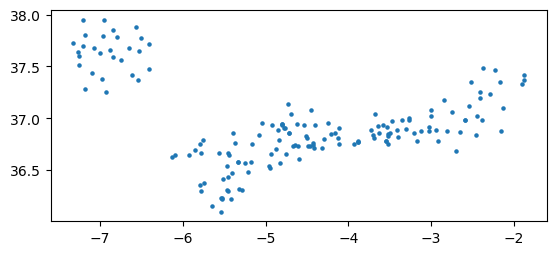

In [73]:
stations.plot(markersize=5);

## Time series

### Gauging stations

In [54]:
# import time series
HQ = pd.read_csv(path / 'raw' / 'timeseries' / 'nivelcaudalrios.txt', index_col=0, parse_dates=True, dayfirst=False)
HQ.index.name = 'Local_ID'
HQ.columns = ['sensor', 'datetime', 'stage', 'discharge']
HQ.datetime = pd.to_datetime(HQ.datetime)

# reorganize the data
gauge_ts = {}
for ID in HQ.index.unique():
    HQ_i = HQ.loc[ID].copy()
    HQ_i.set_index('datetime', drop=True, inplace=True)
    HQ_i.drop('sensor', axis=1, inplace=True)
    gauge_ts[ID] = HQ_i

In [78]:
# export attributes of the gauging stations
path_attr = path / 'processed' / 'gauges' / 'attributes'
path_attr.mkdir(parents=True, exist_ok=True)
mask_gauge = stations.loc[stations['type'] == 'GAUGE'].index
stations.loc[mask_gauge].drop('geometry', axis=1).to_csv(path_attr / 'gauges_hidrosur.csv')

  0%|          | 0/9 [00:00<?, ?it/s]

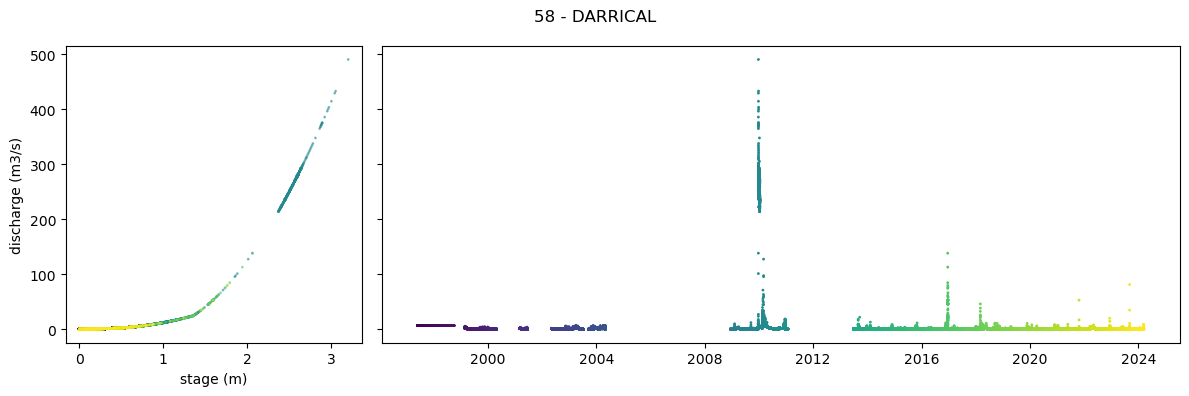

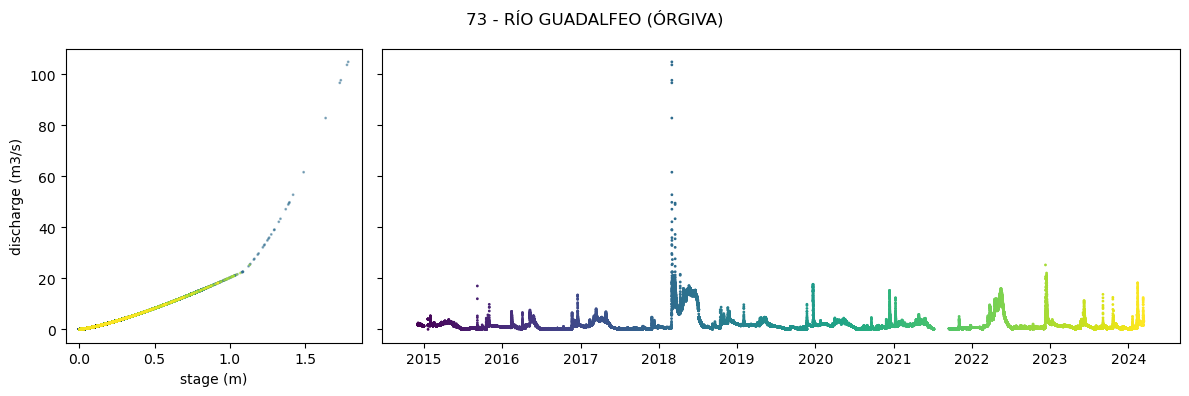

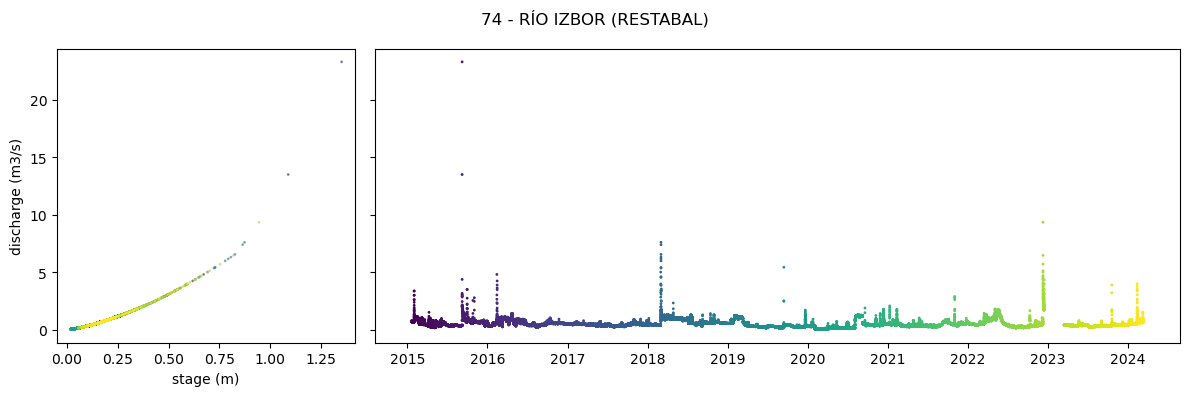

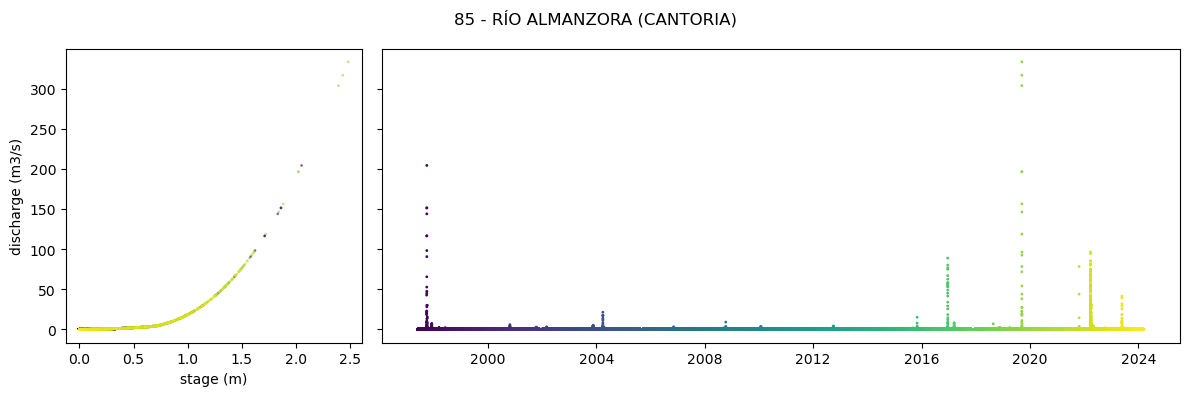

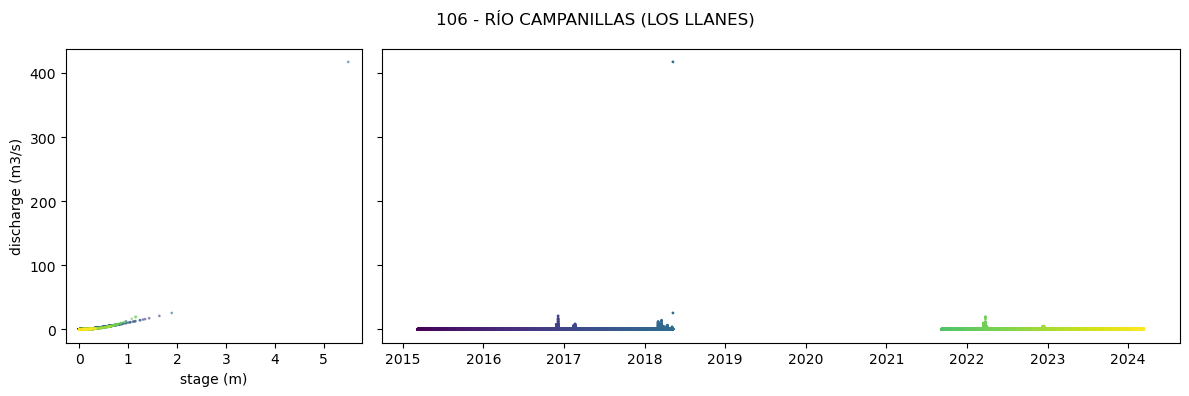

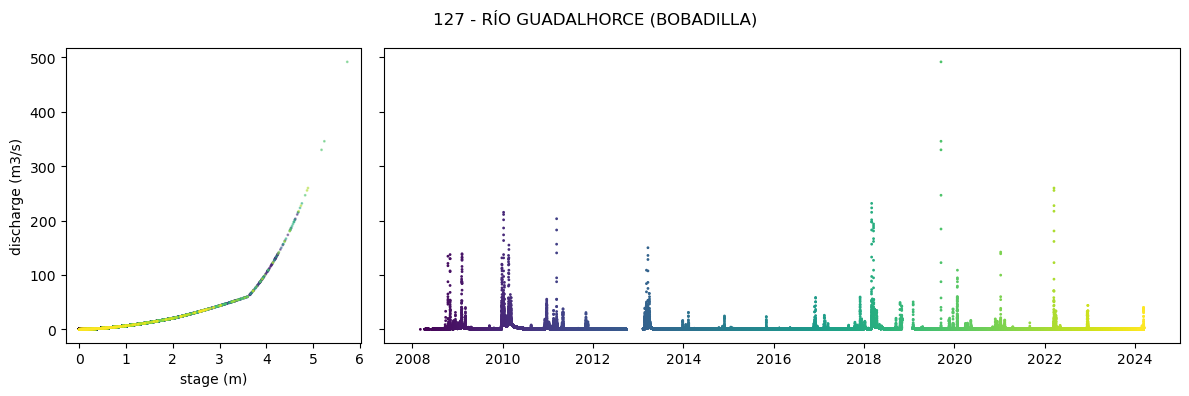

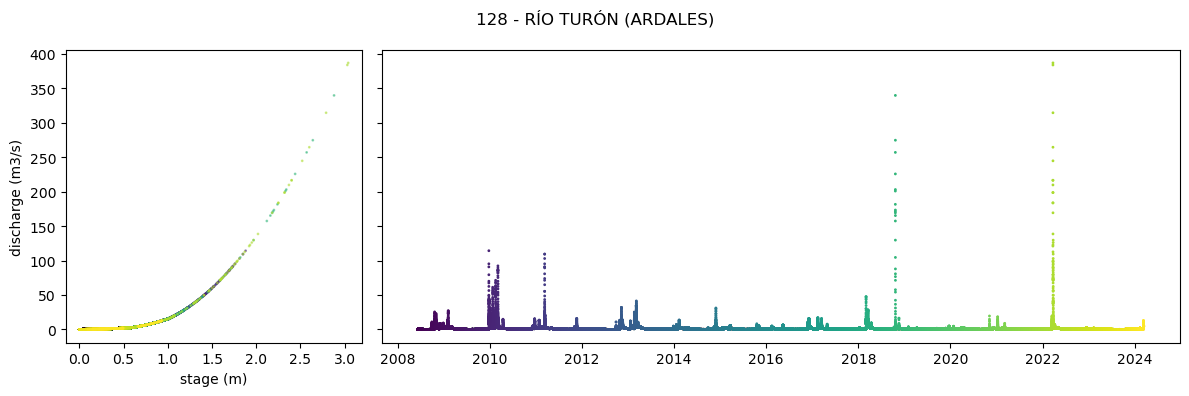

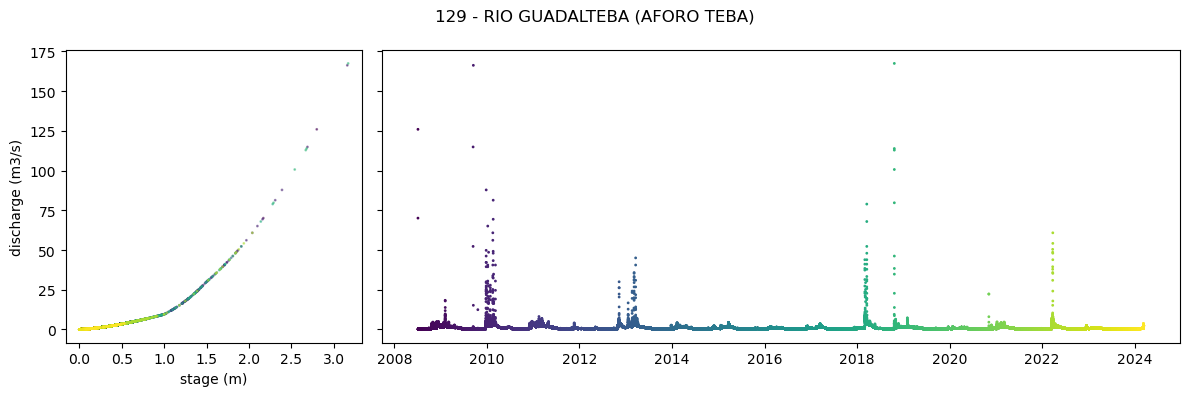

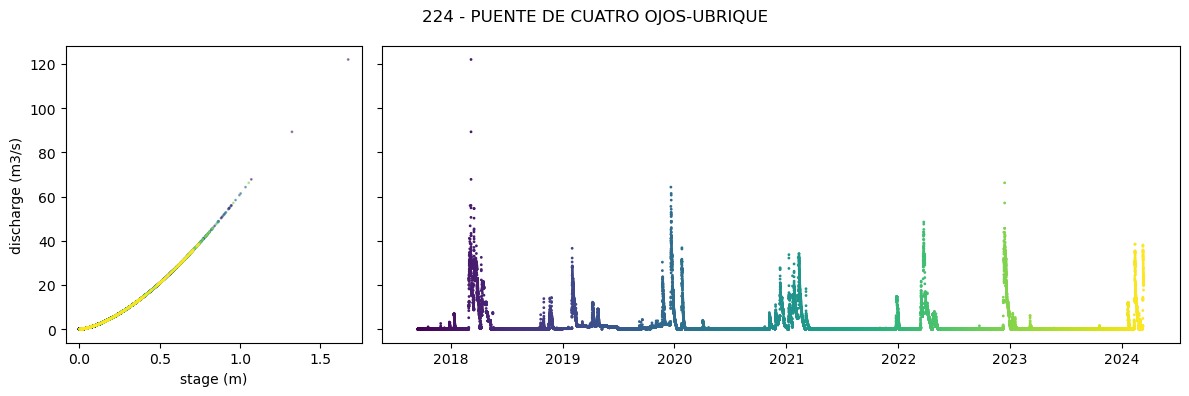

In [73]:
path_ts = path / 'processed' / 'gauges' / 'timeseries'
path_plot = path_ts / 'plots'
path_plot.mkdir(parents=True, exist_ok=True)
for ID, df in tqdm(gauge_ts.items()):
   
    # export
    df.to_csv(path_ts / f'{ID:03}.csv')

    # plot
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True, gridspec_kw={'width_ratios': [1, 2.7]}, tight_layout=True)
    ax[0].scatter(df.stage, df.discharge, s=1, c=df.index, cmap='viridis', alpha=.5)
    ax[0].set(xlabel='stage (m)',
              ylabel='discharge (m3/s)')
    ax[1].scatter(df.index, df.discharge, s=1, c=df.index, cmap='viridis')
    fig.suptitle('{0} - {1}'.format(ID, stations.loc[stations['type'] == 'GAUGE'].loc[ID, 'name']));
    plt.savefig(path_plot / f'{ID:03}.jpg', dpi=300, bbox_inches='tight')

### Reservoirs

In [68]:
# correspondence between the reservoir ID and the gauge ID that represents the inflow to that reservoir
map_reservoir_gauge = {31: 128,
                       29: 129,
                       30: 127,
                       19: 106,
                       58: 58,
                       64: 74,
                       84: 85}

In [70]:
# import time series
LV = pd.read_csv(path / 'raw' / 'timeseries' / 'nivelvolum.txt', index_col=0, parse_dates=True, dayfirst=False)
LV.index.name = 'Local_ID'
LV.columns = ['datetime', 'level', 'volume']
LV.datetime = pd.to_datetime(LV.datetime)

# reorganize data by ID
reservoir_ts = {}
for ID in tqdm(LV.index.unique().tolist()):
    # extract time series for the reservoir ID
    LV_i = LV.loc[ID].copy()
    LV_i.set_index('datetime', drop=True, inplace=True)
    
    # correct erroneous level values
    LV_i.loc[LV_i.level <= 0, 'level'] = np.nan
    
    # add inflow from associated gauging station
    if ID in map_reservoir_gauge.keys():
        gauge_id = map_reservoir_gauge[ID]
        LV_i['inflow'] = gauge_ts[gauge_id]['discharge']
    
    # save in the dictionary
    reservoir_ts[ID] = LV_i

  0%|          | 0/20 [00:00<?, ?it/s]

In [86]:
# export reservoir attributes
path_attr = path / 'processed' / 'reservoirs' / 'attributes' 
path_attr.mkdir(parents=True, exist_ok=True)
mask_reservoir = stations.loc[stations['type'] == 'RESERVOIR'].index
stations.loc[mask_reservoir].drop('geometry', axis=1).to_csv(path_attr / 'reservoirs_hidrosur_basic.csv')

  0%|          | 0/20 [00:00<?, ?it/s]

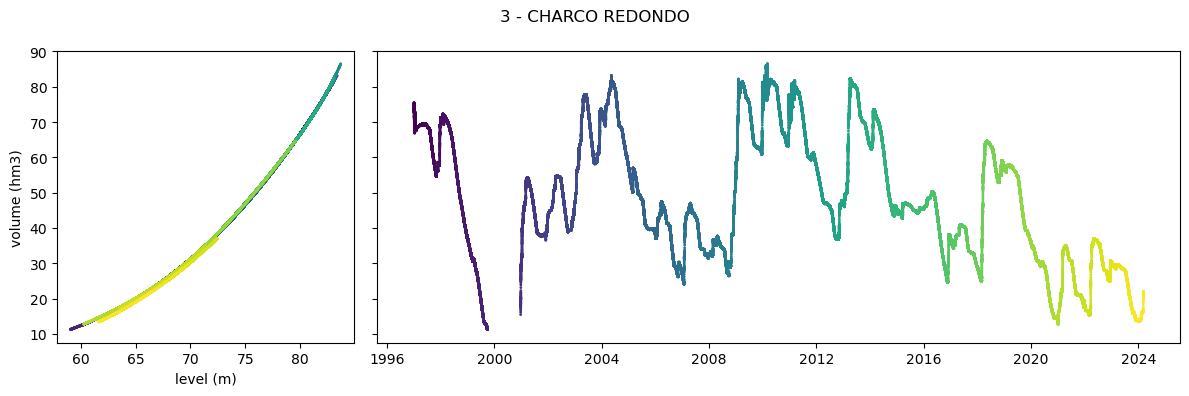

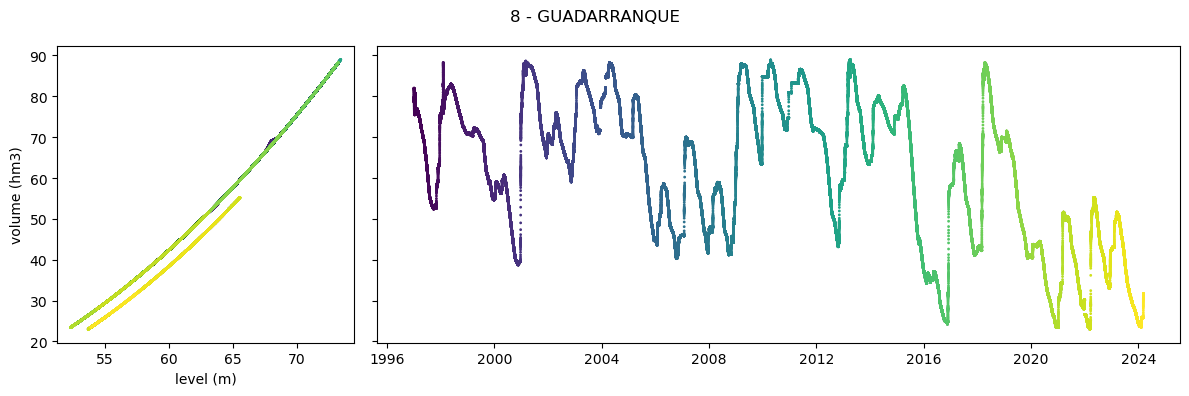

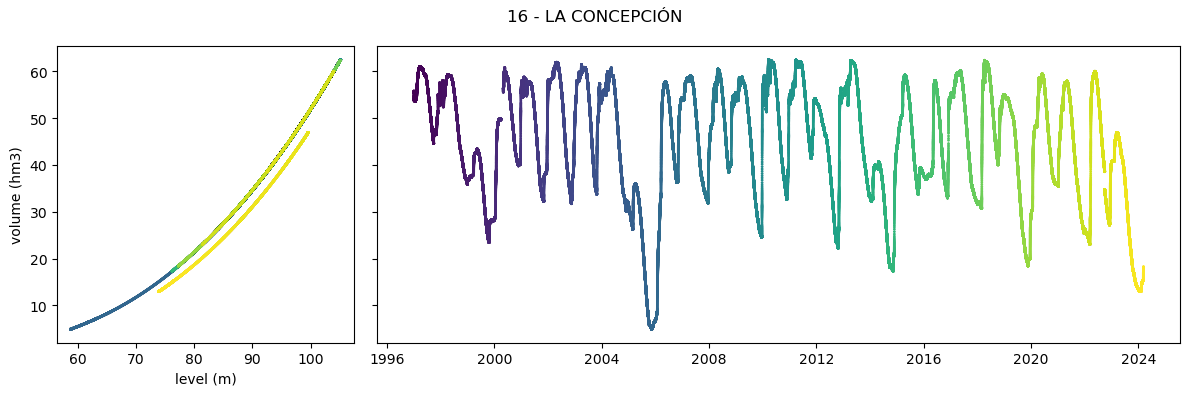

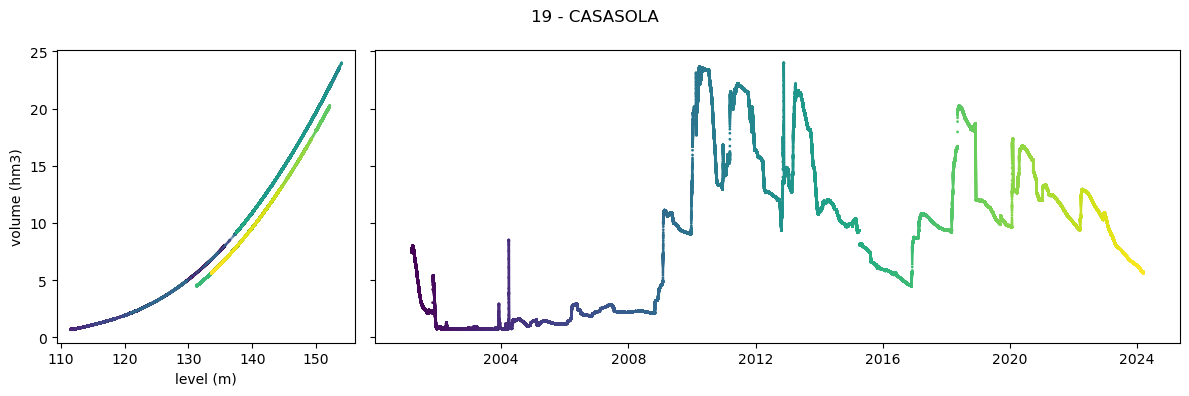

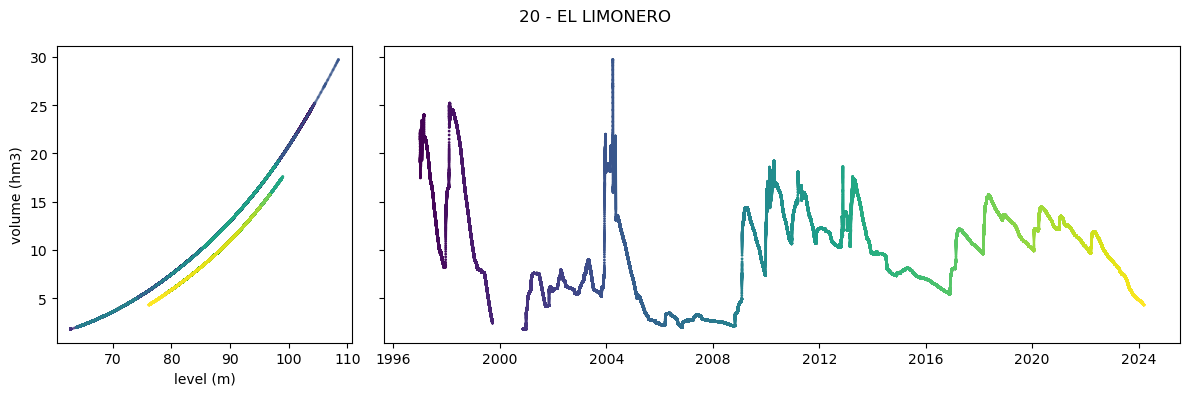

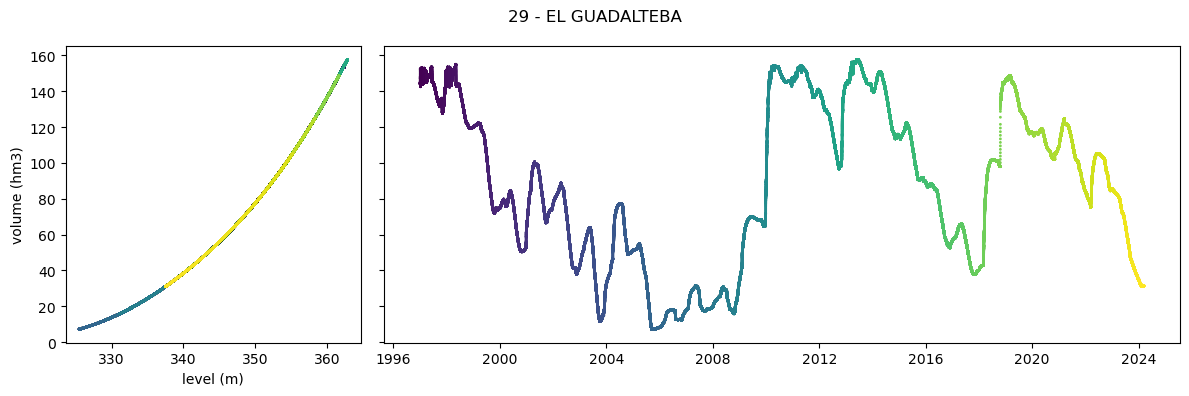

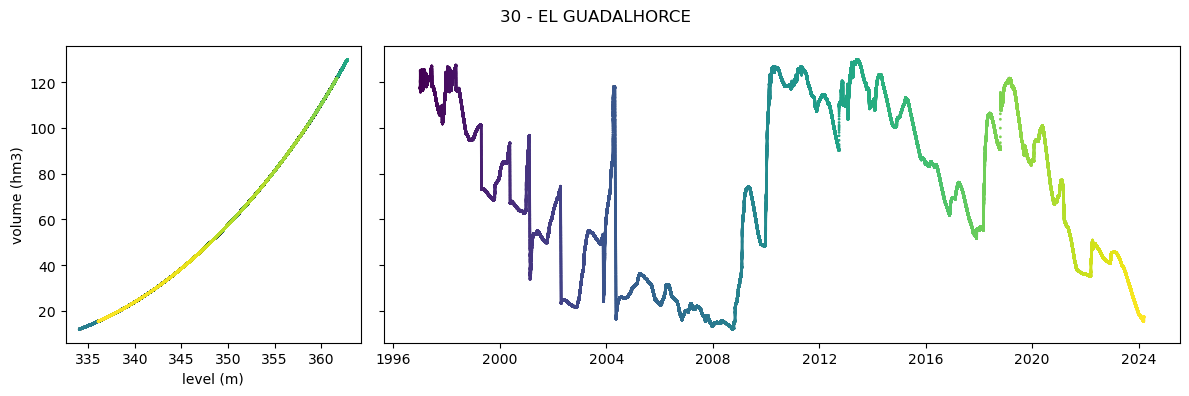

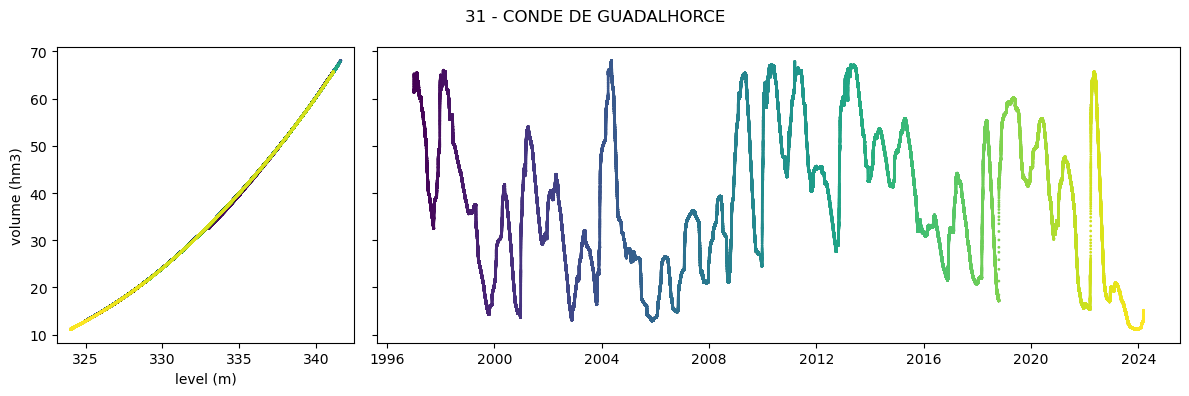

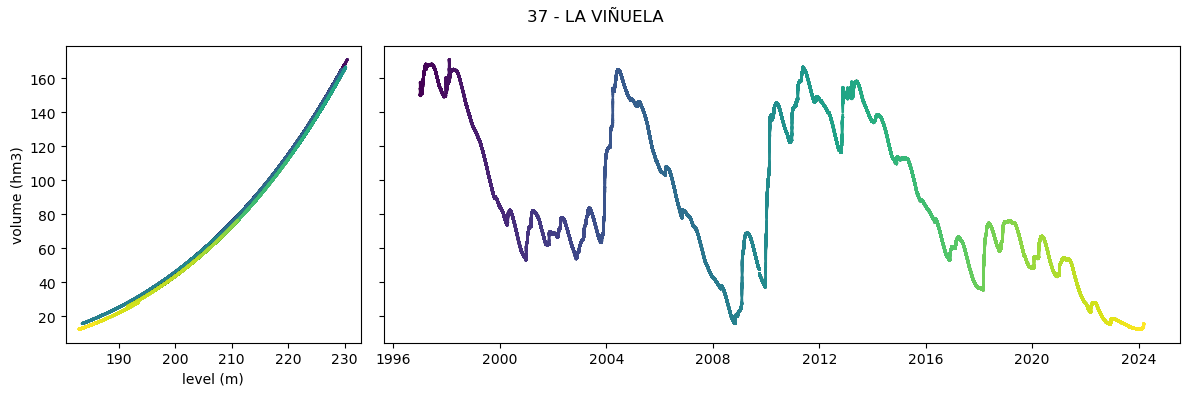

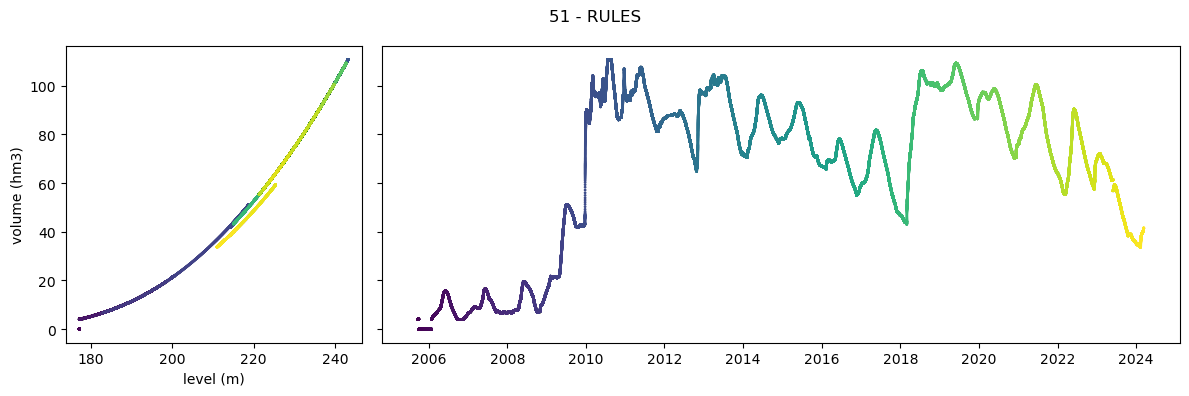

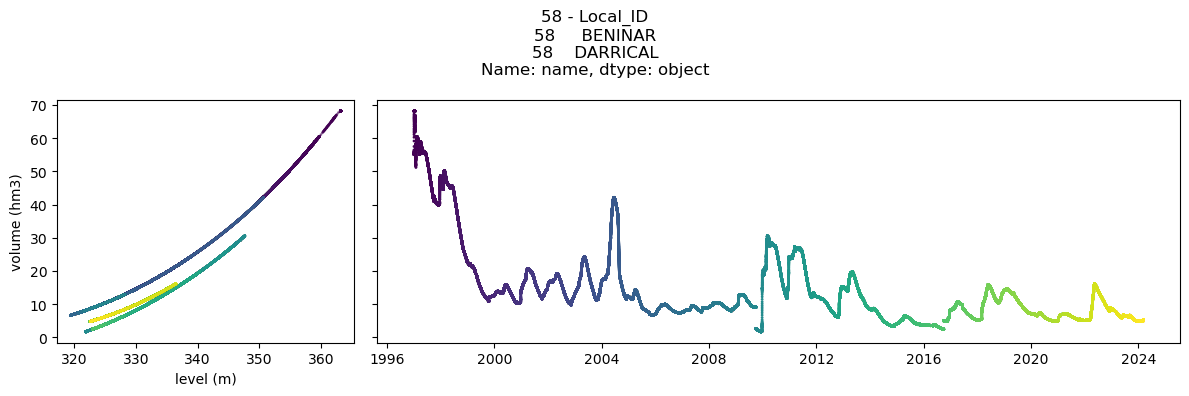

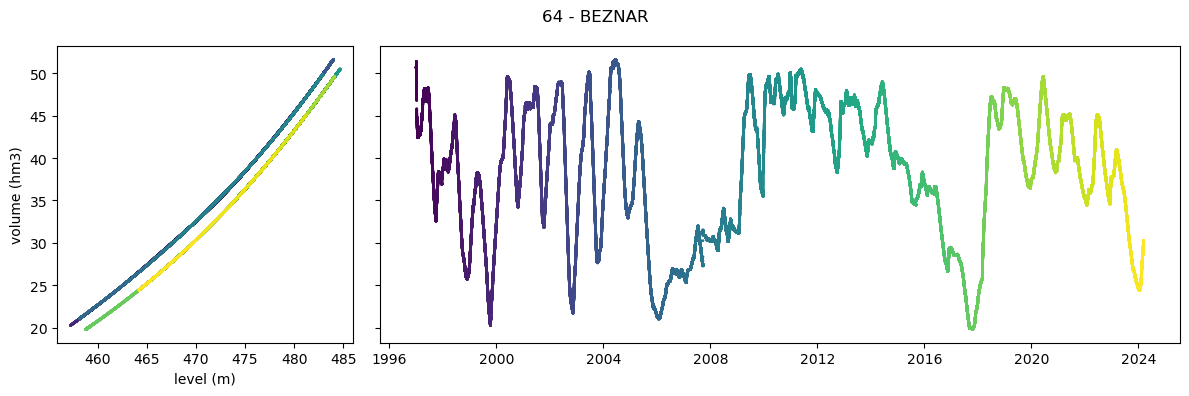

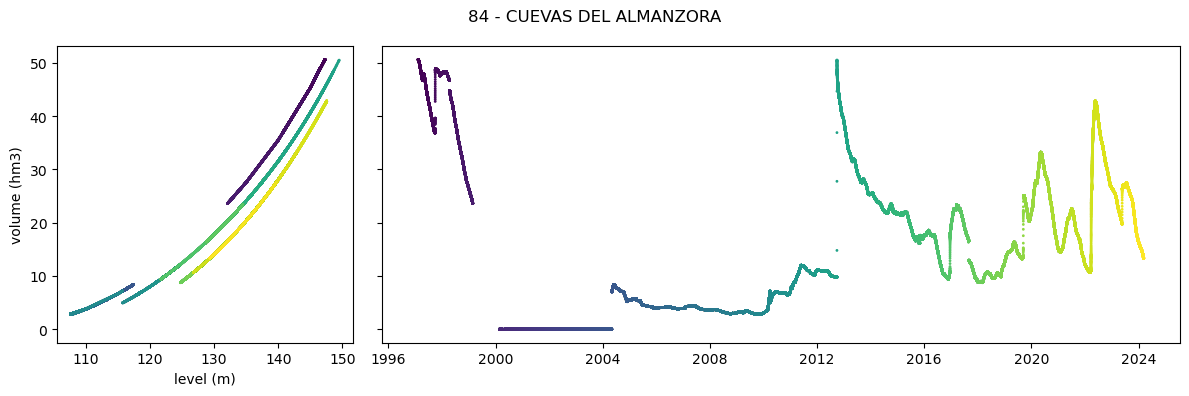

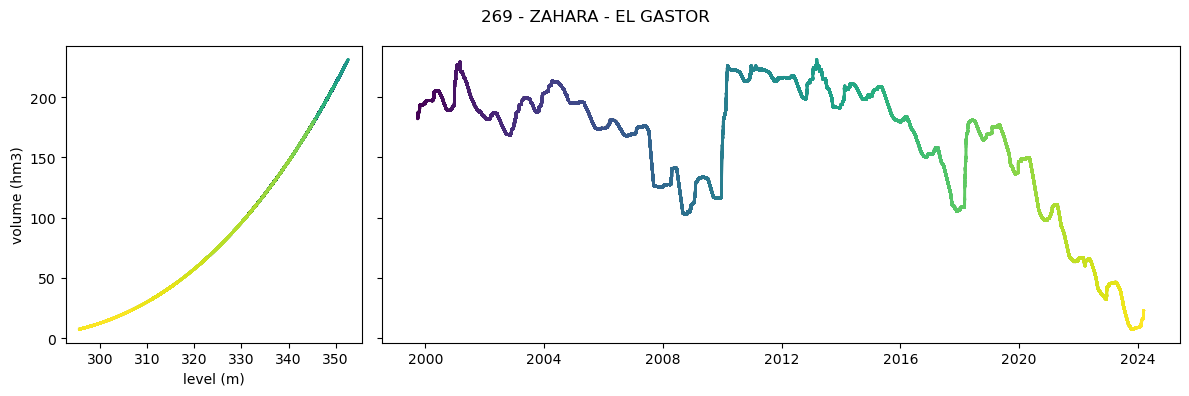

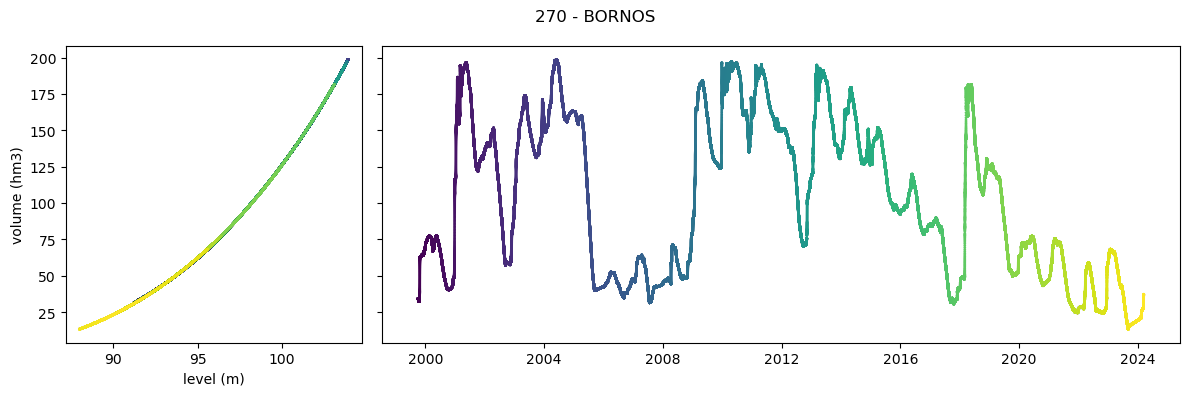

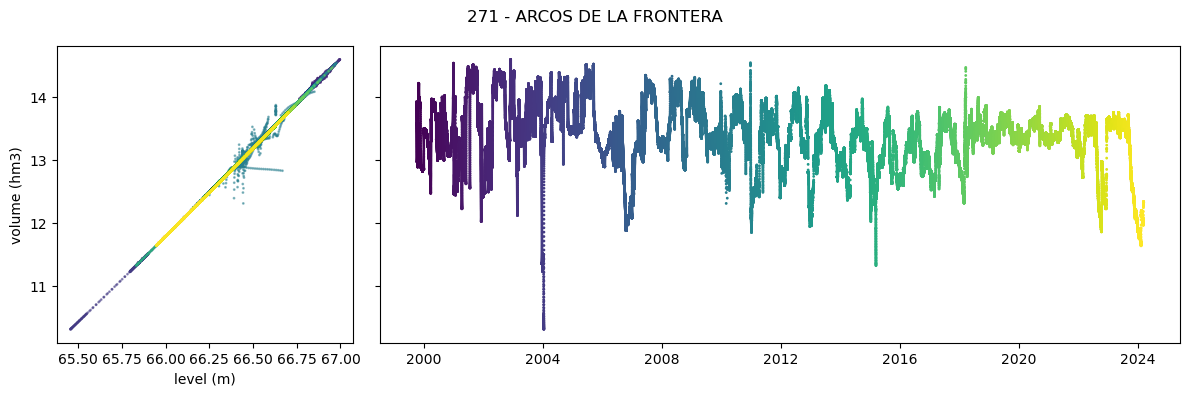

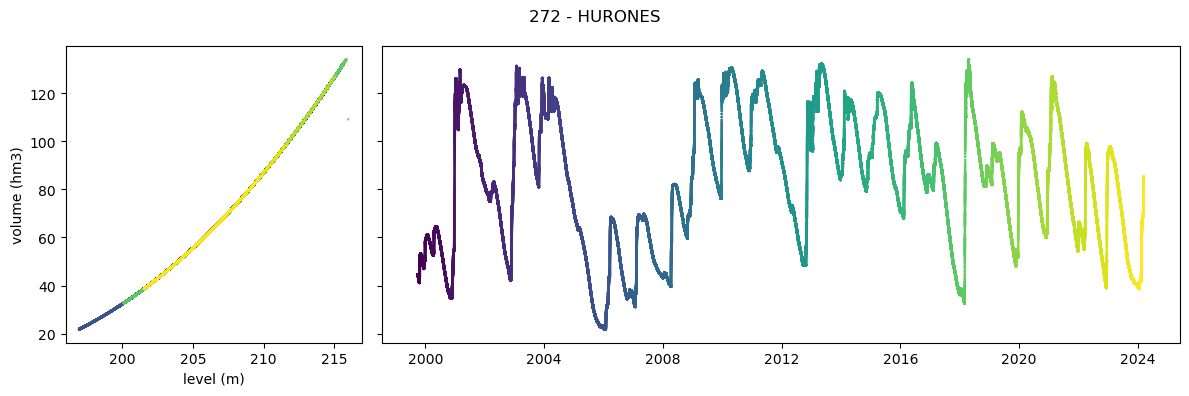

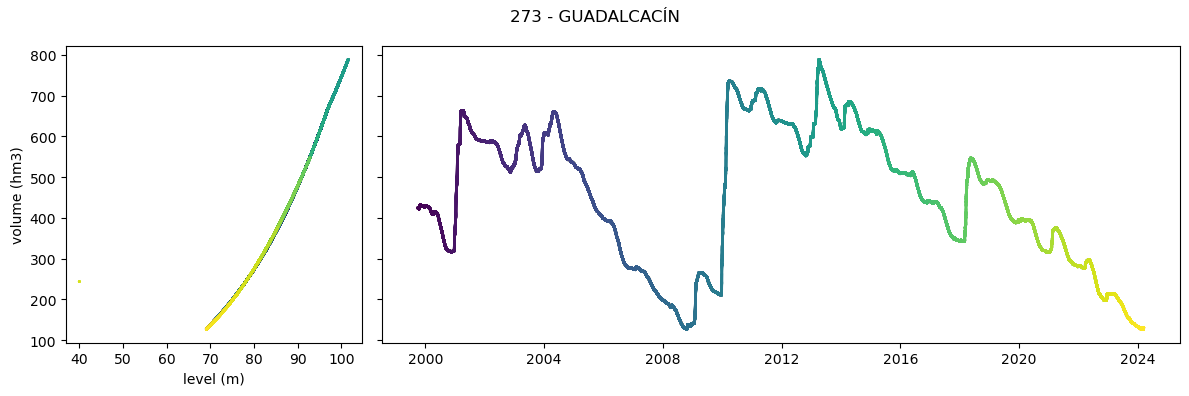

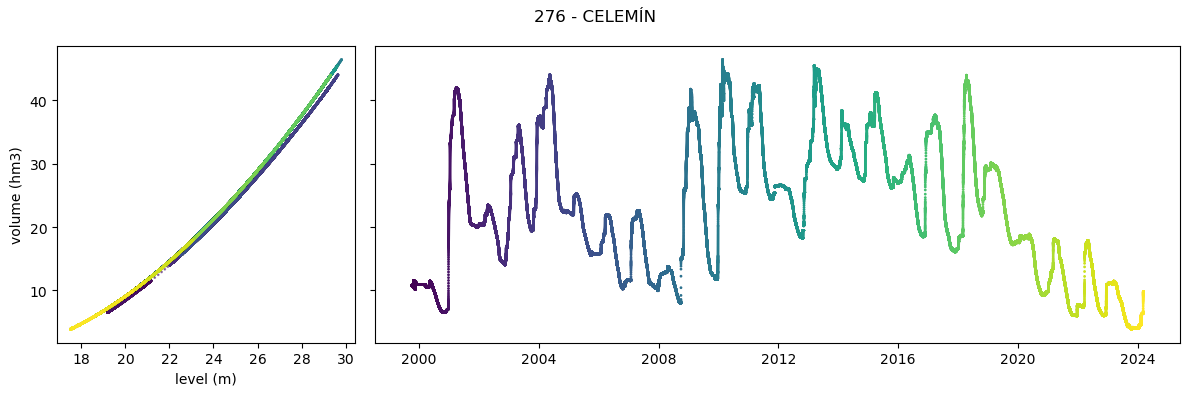

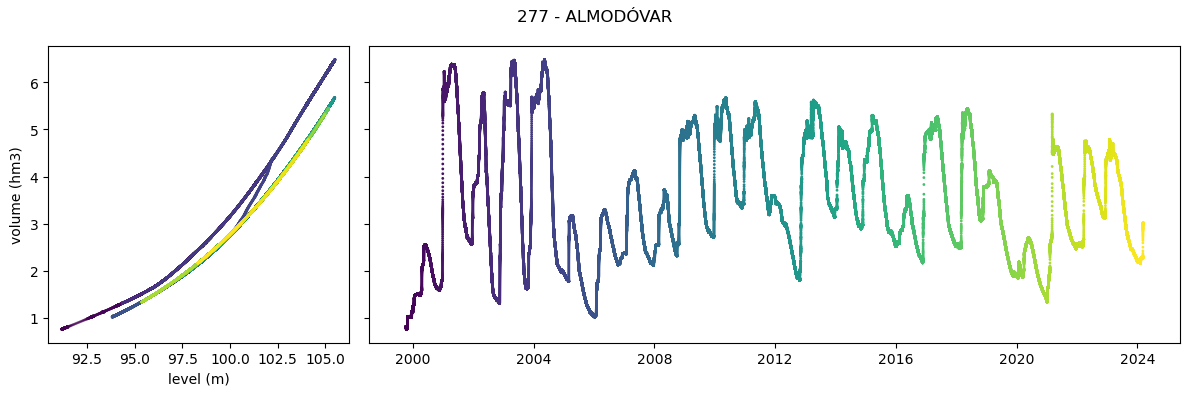

In [79]:
path_ts = path / 'processed' / 'reservoirs' / 'timeseries' 
path_plot = path_ts / 'plots'
path_plot.mkdir(parents=True, exist_ok=True)
for ID, df in tqdm(reservoir_ts.items()):
    
    # export
    df.to_csv(path_ts / f'{ID:03}.csv')
    
    # plot
    fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True, gridspec_kw={'width_ratios': [1, 2.7]}, tight_layout=True)
    ax[0].scatter(df.level, df.volume, s=1, c=df.index, cmap='viridis', alpha=.5)
    ax[0].set(xlabel='level (m)',
              ylabel='volume (hm3)')
    ax[1].scatter(df.index, df.volume, s=1, c=df.index, cmap='viridis')
    fig.suptitle('{0} - {1}'.format(ID, stations.loc[mask_reservoir].loc[ID, 'name']))
    plt.savefig(path_plot / f'{ID:03}.jpg', dpi=300, bbox_inches='tight')